# Tutorial: Scope Data

- What if the SPE spectrum data I have is already binned, and I no longer have access to the individual charges?
- What if the data I measured was triggered on a signal, and I have no pedestal peak in the data?

Data that falls under both of these chategories is demonstrated here, taken using a Silicon Photomultiplier connected to a scope. It utilises the `ChargeContainer.from_prebinned` classmethod and the `disable_pedestal` argument, otherwise the process is identical (however, the `UnbinnedNLL` is naturally not available in this usecase).

In [1]:
from spefit.dataset import Dataset
from spefit.pdf import PDFParameter, SiPMModifiedPoisson
from spefit.cost import BinnedNLL
from spefit.fitter import minimize_with_iminuit
from spefit.estimate import estimate_spe_parameters, find_spe_peaks
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

/Users/Jason/Software/spefit/spefit/fitter.py:6: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import trange


## Load Data

The data from the scope has been saved into a numpy file. We then used the `ChargeContainer.from_prebinned` classmethod to prepare the histogram for `spefit`

In [2]:
ChargeContainer.from_prebinned?

Object `ChargeContainer.from_prebinned` not found.


Text(0, 0.5, 'Counts')

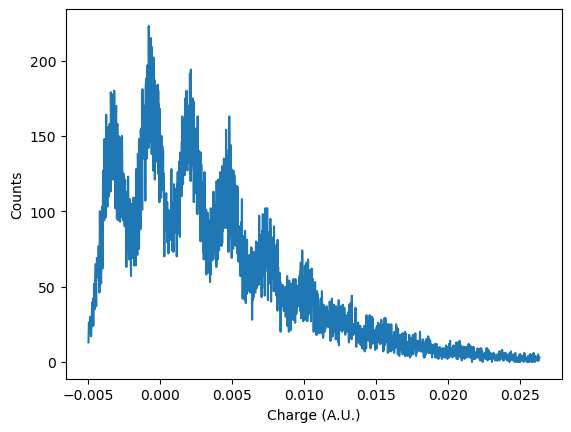

In [14]:
x, y = np.load("scope_data.npy")
mask = x > -0.005
x = x[mask]
y = y[mask]
plt.plot(x, y)
plt.xlabel("Charge (A.U.)")
plt.ylabel("Counts")

In [15]:
c = Dataset.from_prebinned(x, y)
charges = [c]  # Only 1 illumination here

## PDF

When initialising the PDF class, it is possible to specify `disable_pedestal=True` for data where the pedestal peak is not included (due to only storing events which triggered).

However, as can be seen on the x-axis above, the units for the charge are very small. The initial parameters (below) are not applicable for this dataset, and the fitting procedure may have difficulties. Therefore, it is wise to update the initial parameters.

Text(0, 0.5, 'Probability')

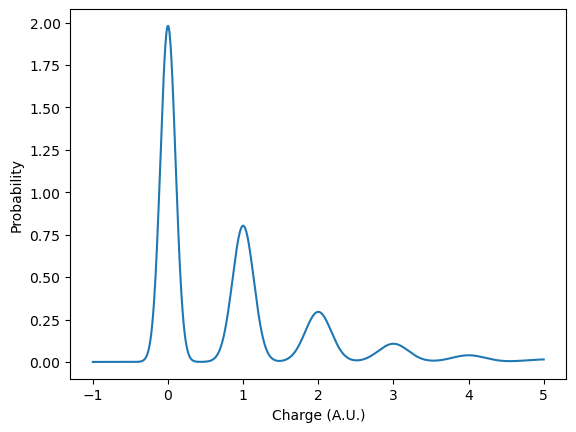

In [16]:
pdf = SiPMModifiedPoisson()

initial_x = np.linspace(-1, 5, 1000)
initial_y = pdf(initial_x, pdf.initial, 0)

plt.plot(initial_x, initial_y, label="Original Initial")
plt.xlabel("Charge (A.U.)")
plt.ylabel("Probability")

## Initial Parameter Estimate

There are many ways one could estimate the parameters for the initial values of the fit. `spefit` provides an estimation approach using `scipy.find_peaks` and the formula for the ratio between peak heights in a simple SPE spectra. The resulting initial parameters are more appropriate for this dataset:

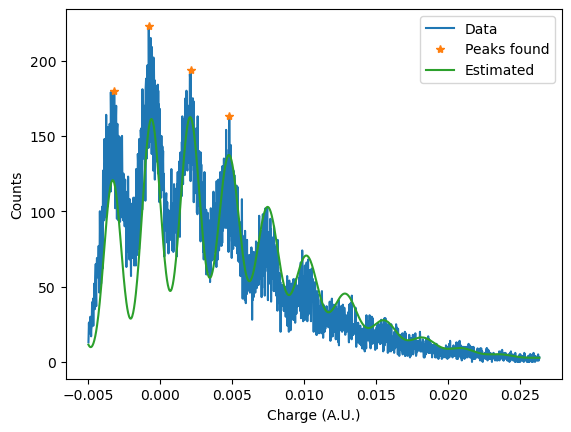

In [17]:
peak_x, peak_y, peak_sigma = find_spe_peaks(x, y, max_n_peaks=4)
estimates = estimate_spe_parameters(peak_x, peak_y, peak_sigma, disable_pedestal=True)
parameters = {k: PDFParameter(k, v) for k, v in estimates.items()}
pdf = SiPMModifiedPoisson(**parameters)

initial_x = np.linspace(x[0], x[-1], 1000)
initial_array = np.array(pdf.initial)
initial_y = pdf(initial_x, initial_array, 0)
plt.plot(x, y, label="Data")
plt.plot(peak_x, peak_y, '*', label="Peaks found")
plt.plot(initial_x, initial_y*np.trapz(y, x), label="Estimated")
plt.xlabel("Charge (A.U.)")
plt.ylabel("Counts")
plt.legend()

## Perform the Fit

With the ChargeContainer and PDF prepared, the rest of the chain proceeds as normal:

eped = -5.96e-03 ± 1.04e-05
eped_sigma = 6.85e-04 ± 7.45e-06
pe = 2.66e-03 ± 4.01e-06
pe_sigma = 2.76e-04 ± 7.54e-06
opct = 2.35e-01 ± 2.67e-03
lambda_ = 2.48e+00 ± 1.07e-02


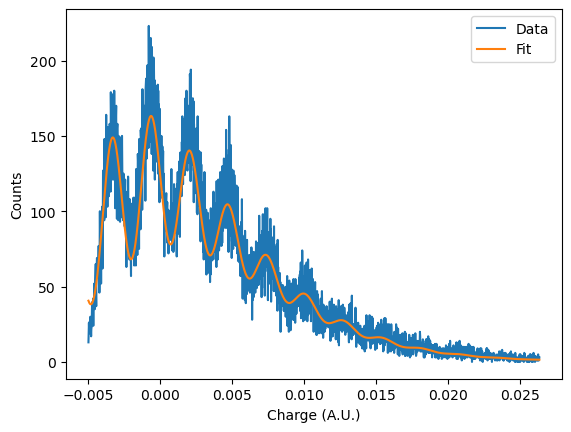

In [18]:
cost = BinnedNLL(pdf, charges)
values, errors = minimize_with_iminuit(cost)

values_array = np.array(list(values.values()))
fit_x = np.linspace(x[0], x[-1], 1000)
fit_y = pdf(fit_x, values_array, 0)

plt.plot(x, y, label="Data")
plt.plot(fit_x, fit_y*np.trapz(y, x), label="Fit")
plt.xlabel("Charge (A.U.)")
plt.ylabel("Counts")
plt.legend()

for param in values.keys():
    print(f"{param} = {values[param]:.2e} ± {errors[param]:.2e}")